# GridSearch
- GridSearch 를 진행하여 최적화 모델을 찾아봅니다.

In [2]:
import warnings

# your regular code
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

RANDOM_STATE = 2023

# Feature 생성
- X_trn, y_trn 을 생성합니다.

In [3]:
from datasets import HomeData
from configs.preprocess_config import config
from copy import deepcopy

config = deepcopy(config)

input_data = config.get('input_data')
add_data = config.get('add_data')
options = config.get('options')
output_data = config.get('output_data')

options["x_scaler"] = None
options["y_scaler"] = None

trn_X, trn_y, tst_X, y_scaler = HomeData(
  **input_data,
  **add_data,
  **options
).preprocess()

(39609, 31)
(10963, 31)


/home/sdk/miniconda3/envs/MathAI/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.draw()
/home/sdk/miniconda3/envs/MathAI/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.draw()
/home/sdk/miniconda3/envs/MathAI/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fig.canvas.draw()
/home/sdk/miniconda3/envs/MathAI/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.draw()
/home/sdk/miniconda3/envs/MathAI/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.draw()
/home/sdk/miniconda3/envs/MathAI/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: 

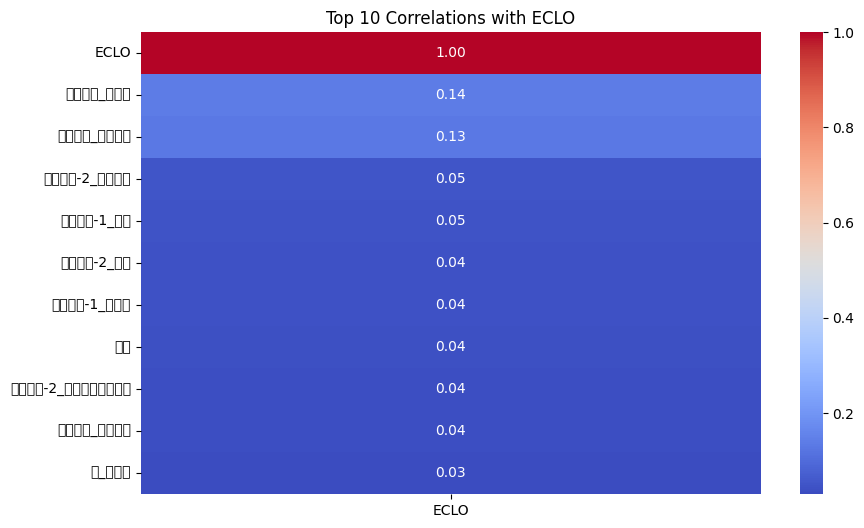

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.concat([trn_X, trn_y], axis=1)

correlation_matrix = df.corr()
# 상관 행렬 계산
eclo_correlation = correlation_matrix['ECLO'].abs().nlargest(11)

# 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(eclo_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 10 Correlations with ECLO')
plt.show()

### Train set / Validation set split
- trn_X 와 trx_y 를 train set 과 validation set 으로 분리시켜 줍니다.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(trn_X, trn_y, test_size=0.3, random_state=RANDOM_STATE)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# 실행
- LinearRegression
- Ridge
- Lasso

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import numpy as np

linear_pipe = Pipeline([
    ('scaler', FeatureUnion([
        ('standard_scaler', StandardScaler()),
        ('robust_scaler', RobustScaler()),
        ('minmax_scaler', MinMaxScaler())
    ])),
    ('reg', LinearRegression())
])

ridge_pipe = Pipeline([
    ('scaler', FeatureUnion([
        ('standard_scaler', StandardScaler()),
        ('robust_scaler', RobustScaler()),
        ('minmax_scaler', MinMaxScaler())
    ])),
    ('reg', Ridge(random_state=RANDOM_STATE))
])

lasso_pipe = Pipeline([
    ('scaler', FeatureUnion([
        ('standard_scaler', StandardScaler()),
        ('robust_scaler', RobustScaler()),
        ('minmax_scaler', MinMaxScaler())
    ])),
    ('reg', Lasso(random_state=RANDOM_STATE))
])

linear_params = {}

ridge_params = {
    'reg__alpha': [0.1, 1, 10, 100]
}

lasso_params = {
    'reg__alpha': [0.1, 1, 10, 100]
}


linear_grid = GridSearchCV(linear_pipe, linear_params, scoring='neg_mean_squared_error', cv=3)
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, scoring='neg_mean_squared_error', cv=3)
lasso_grid = GridSearchCV(lasso_pipe, lasso_params, scoring='neg_mean_squared_error', cv=3)

linear_grid.fit(X_train, y_train)
ridge_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)

linear_test_mse = mean_squared_error(y_test, linear_grid.predict(X_test))
ridge_test_mse = mean_squared_error(y_test, ridge_grid.predict(X_test))
lasso_test_mse = mean_squared_error(y_test, lasso_grid.predict(X_test))

linear_test_r2 = r2_score(y_test, linear_grid.predict(X_test))
ridge_test_r2 = r2_score(y_test, ridge_grid.predict(X_test))
lasso_test_r2 = r2_score(y_test, lasso_grid.predict(X_test))

print("Linear 테스트 MSE:", linear_test_mse)
print("Linear 테스트 R2:", linear_test_r2)
print("ridge 베스트 파라미터:", ridge_grid.best_params_)
print("ridge 테스트 MSE:", ridge_test_mse)
print("ridge 테스트 R2:", ridge_test_r2)
print("lasso 베스트 파라미터:", lasso_grid.best_params_)
print("lasso 테스트 MSE:", lasso_test_mse)
print("lasso 테스트 R2 스코어:", lasso_test_r2)


Linear 테스트 MSE: 10.168343400640198
Linear 테스트 R2: 0.026962718072043756
ridge 베스트 파라미터: {'reg__alpha': 100}
ridge 테스트 MSE: 10.167895416786823
ridge 테스트 R2: 0.027005586902674295
lasso 베스트 파라미터: {'reg__alpha': 0.1}
lasso 테스트 MSE: 10.243576038140052
lasso 테스트 R2 스코어: 0.019763496112199186


# 실행
- DecisionTreeRegressor
- RandomForestRegressor
- SVR

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# dt_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('minmax_scaler', MinMaxScaler()),
#     ('reg', DecisionTreeRegressor(random_state=2023))
# ])

rf_pipe = Pipeline([
    ('scaler', FeatureUnion([
        ('standard_scaler', StandardScaler()),
        ('minmax_scaler', MinMaxScaler()),
    ])),
    ('reg', RandomForestRegressor(random_state=2023))
])

# svr_pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('minmax_scaler', MinMaxScaler()),
#     ('reg', SVR())
# ])

# dt_params = {
#     'reg__max_depth': [None, 10, 20, 30],
#     'reg__min_samples_split': [2, 5, 10],
#     'reg__min_samples_leaf': [1, 2, 4]
# }

rf_params = {
    'reg__n_estimators': [10, 50, 100],
    'reg__max_depth': [None, 10, 20, 30],
    'reg__min_samples_split': [2, 5, 10],
    'reg__min_samples_leaf': [1, 2, 4]
}

# svr_params = {
#     'reg__C': [0.1, 1, 10],
#     'reg__epsilon': [0.01, 0.1, 1],
#     'reg__kernel': ['linear', 'rbf']
# }

# dt_grid = GridSearchCV(dt_pipe, dt_params, scoring='neg_mean_squared_error', cv=3)
rf_grid = GridSearchCV(rf_pipe, rf_params, scoring='neg_mean_squared_error', cv=3)
# svr_grid = GridSearchCV(svr_pipe, svr_params, scoring='neg_mean_squared_error', cv=3)

# dt_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)
# svr_grid.fit(X_train, y_train)

# dt_test_mse = mean_squared_error(y_test, dt_grid.predict(X_test))
rf_test_mse = mean_squared_error(y_test, rf_grid.predict(X_test))
# svr_test_mse = mean_squared_error(y_test, svr_grid.predict(X_test))

# dt_test_r2 = r2_score(y_test, dt_grid.predict(X_test))
rf_test_r2 = r2_score(y_test, rf_grid.predict(X_test))
# svr_test_r2 = r2_score(y_test, svr_grid.predict(X_test))

# print("Decision Tree 베스트 파라미터:", dt_grid.best_params_)
# print("Decision Tree 테스트 MSE:", dt_test_mse)
# print("Decision Tree 테스트 R2 스코어:", dt_test_r2)

print("Random Forest 베스트 파라미터:", rf_grid.best_params_)
print("Random Forest 테스트 MSE:", rf_test_mse)
print("Random Forest 테스트 R2 스코어:", rf_test_r2)

# print("SVR 베스트 파라미터:", svr_grid.best_params_)
# print("SVR 테스트 MSE:", svr_test_mse)
# print("SVR 테스트 R2 스코어:", svr_test_r2)


Random Forest 베스트 파라미터: {'reg__max_depth': 10, 'reg__min_samples_leaf': 4, 'reg__min_samples_split': 10, 'reg__n_estimators': 100}
Random Forest 테스트 MSE: 10.161970002866724
Random Forest 테스트 R2 스코어: 0.027572606369655417


In [43]:
ran = RandomForestRegressor(n_estimators=4, max_depth=10, random_state=2023)

/home/sdk/miniconda3/envs/MathAI/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


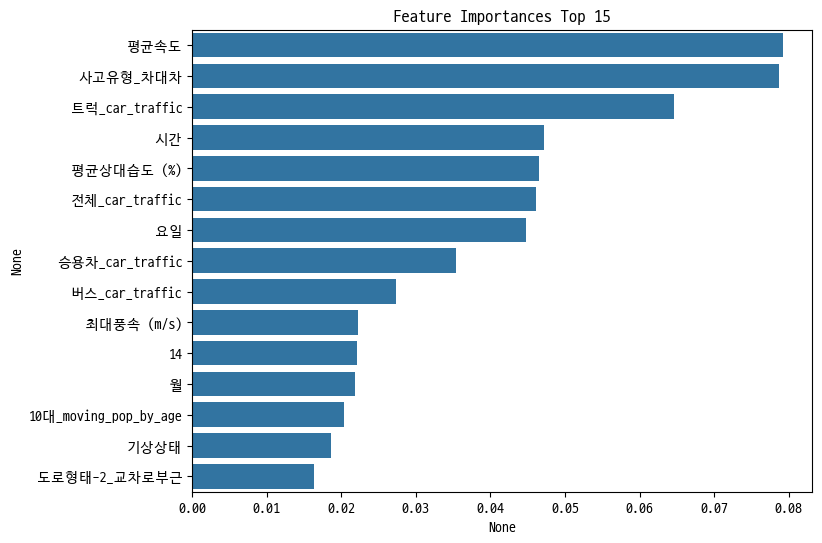

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(pd.DataFrame(y_train))

ran.fit(X_scaled, y_scaled)

ser = pd.Series(ran.feature_importances_, index=X_train.columns)

# 내림차순 정렬을 이용한다, 중요도 탑 15개 출력
top15 = ser.sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()